In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import theano

In [3]:
def simulate_linear_data(N, beta_0, beta_1, eps_sigma_sq):
    # Create a pandas DataFrame with column 'x' containing
    # N uniformly sampled values between 0.0 and 1.0
    df = pd.DataFrame(
        {"x": 
            np.random.RandomState(42).choice(
                list(map(
                    lambda x: float(x)/100.0, 
                    np.arange(200)
                )), 200, replace=False
            )
        }
    )

    # Use a linear model (y ~ beta_0 + beta_1*x + epsilon) to 
    # generate a column 'y' of responses based on 'x'
    eps_mean = 0.0
    df["y"] = beta_0 + beta_1*df["x"] + np.random.RandomState(42).normal(
        eps_mean, eps_sigma_sq, N
    )

    return df


def glm_mcmc_inference(df, iterations=5000):
    """
    Calculates the Markov Chain Monte Carlo trace of
    a Generalised Linear Model Bayesian linear regression 
    model on supplied data.

    df: DataFrame containing the data
    iterations: Number of iterations to carry out MCMC for
    """
    # Use PyMC3 to construct a model context
    basic_model = pm.Model()
    with basic_model:
        pm.GLM.from_formula("y ~ x", df, family=pm.glm.families.Normal())
        # Use the MHSampler
        step = pm.Metropolis()
        # Calculate the trace
        trace = pm.sample(iterations, step, random_seed=42, progressbar=True)

    return trace

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(0.0, 1.0)

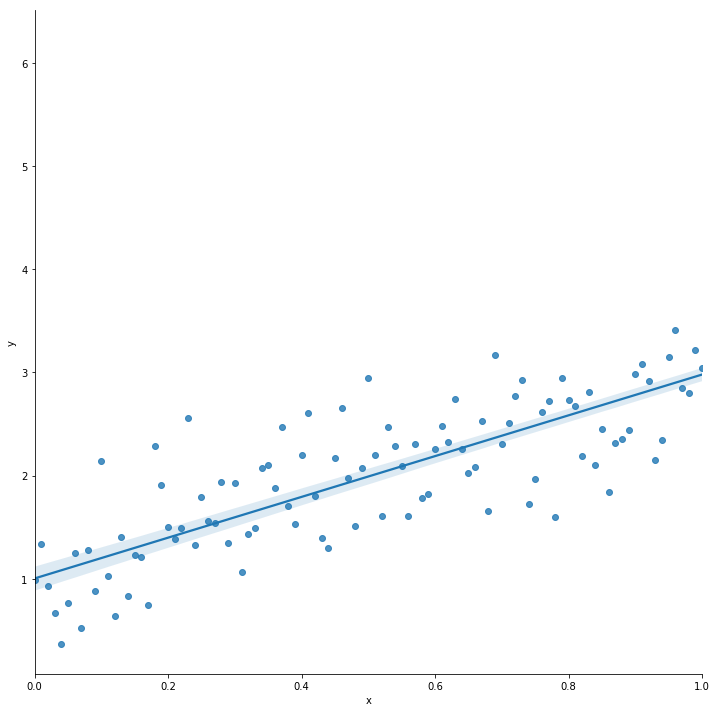

In [4]:
# These are our "true" parameters
beta_0 = 1.0  # Intercept
beta_1 = 2.0  # Slope

# Simulate 100 data points, with a variance of 0.5
N = 200
eps_sigma_sq = 0.5

# Simulate the "linear" data using the above parameters
df = simulate_linear_data(N, beta_0, beta_1, eps_sigma_sq)

# Plot the data, and a frequentist linear regression fit
# using the seaborn package
sns.lmplot(x="x", y="y", data=df, size=10)
plt.xlim(0.0, 1.0)

In [5]:
df.head()

x         y
0  0.95  3.148357
1  0.15  1.230868
2  0.30  1.923844
3  1.58  4.921515
4  1.28  3.442923

In [8]:
y_tensor = theano.shared(df.y.values.astype('float64'))
x_tensor = theano.shared(df.x.values.astype('float64'))

In [26]:
?pm.GLM.from_formula("y ~ x", df, family=pm.glm.families.Normal())

In [40]:
with pm.Model() as basic_model:
    a_prior = pm.Normal('a', mu=0, sd=2, shape=1)
    b_prior = pm.Normal('b', mu=0, sd=2, shape=1)
    sigma_prior = pm.InverseGamma('sigma',alpha=2,beta=2, shape=1)
    u_likelihood = a_prior + b_prior * x_tensor
    y_likelihood = pm.Normal('y', mu=u_likelihood, sd=sigma_prior, observed=y_tensor)
    #pm.GLM.from_formula("y ~ x", df, family=pm.glm.families.Normal())

In [41]:
iterations = 10000
with basic_model:
    step = pm.Metropolis()
    trace = pm.sample(iterations, step, random_seed=42, progressbar=True ,chains=1)

Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [b]
>Metropolis: [a]
  0%|                                                                                        | 0/10500 [00:00<?, ?it/s]


ValueError: Input dimension mis-match. (input[0].shape[0] = 200, input[1].shape[0] = 1)
Apply node that caused the error: Elemwise{Composite{sqr((i0 - (i1 + (i2 * i3))))}}(<TensorType(float64, vector)>, a_shared, b_shared, <TensorType(float64, vector)>)
Toposort index: 2
Inputs types: [TensorType(float64, vector), TensorType(float64, vector), TensorType(float64, vector), TensorType(float64, vector)]
Inputs shapes: [(200,), (1,), (1,), (200,)]
Inputs strides: [(8,), (8,), (8,), (8,)]
Inputs values: ['not shown', array([0.]), array([0.]), 'not shown']
Outputs clients: [[Elemwise{Composite{Switch(i0, (i1 * ((-(i2 * i3)) + i4)), i5)}}(Elemwise{Composite{Cast{int8}(GT(i0, i1))}}.0, TensorConstant{(1,) of 0.5}, Elemwise{Composite{inv(sqr(i0))}}[(0, 0)].0, Elemwise{Composite{sqr((i0 - (i1 + (i2 * i3))))}}.0, Elemwise{Composite{log((i0 * i1))}}.0, TensorConstant{(1,) of -inf}), Elemwise{Composite{Switch(i0, (i1 * ((-(i2 * i3)) + i4)), i5)}}[(0, 3)](Elemwise{Composite{Cast{int8}(GT(i0, i1))}}.0, TensorConstant{(1,) of 0.5}, Elemwise{Composite{inv(sqr(i0))}}[(0, 0)].0, Elemwise{Composite{sqr((i0 - (i1 + (i2 * i3))))}}.0, Elemwise{Composite{log((i0 * i1))}}.0, TensorConstant{(1,) of -inf})]]

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

In [32]:
pm.summary(trace)

mean        sd  mc_error   hpd_2.5  hpd_97.5
Intercept  0.997355  0.064191  0.004649  0.872439  1.109615
x          1.981724  0.054661  0.003968  1.890652  2.090324
sd         0.469316  0.022096  0.000885  0.420146  0.510571

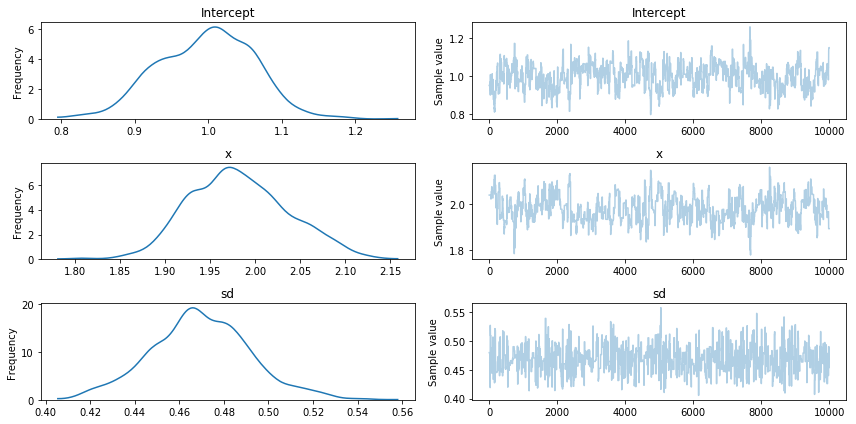

In [33]:
pm.traceplot(trace)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


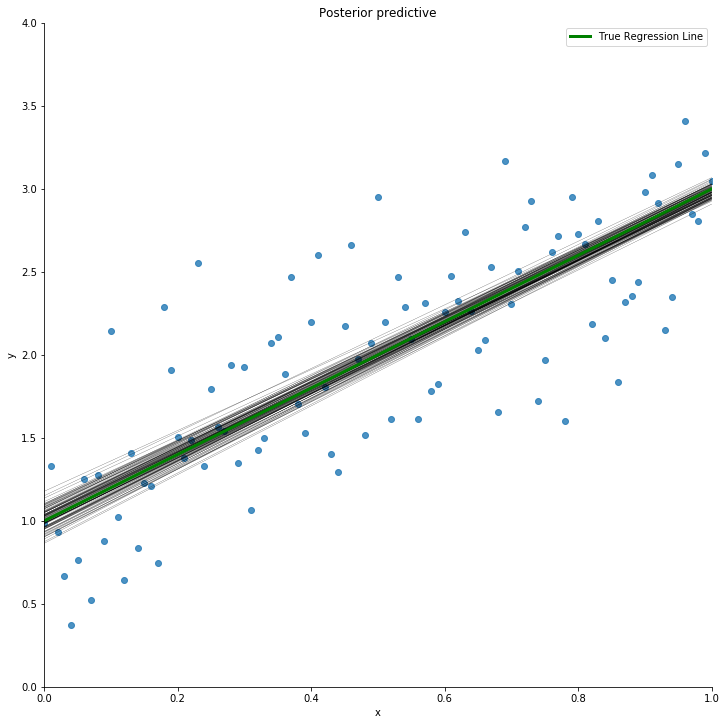

In [24]:
# Plot a sample of posterior regression lines
sns.lmplot(x="x", y="y", data=df, size=10, fit_reg=False)
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 4.0)
pm.plot_posterior_predictive_glm(trace, samples=100)
x = np.linspace(0, 1, N)
y = beta_0 + beta_1*x
plt.plot(x, y, label="True Regression Line", lw=3., c="green")
plt.legend(loc=0)
plt.show()

In [35]:
%%time
with basic_model:
    advi_fit = pm.fit(method=pm.ADVI(), n=30000)

Average Loss = 142.73: 100%|███████████████████████████████████████████████████| 30000/30000 [00:16<00:00, 1867.56it/s]
Finished [100%]: Average Loss = 142.73


Wall time: 19.6 s


mean        sd  mc_error   hpd_2.5  hpd_97.5
a__0      1.006246  0.037742  0.000360  0.930735  1.079122
b__0      1.975599  0.032958  0.000313  1.911517  2.039648
sigma__0  0.473329  0.025843  0.000281  0.422238  0.523168

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001B572B6AAC8>,
      dtype=object)

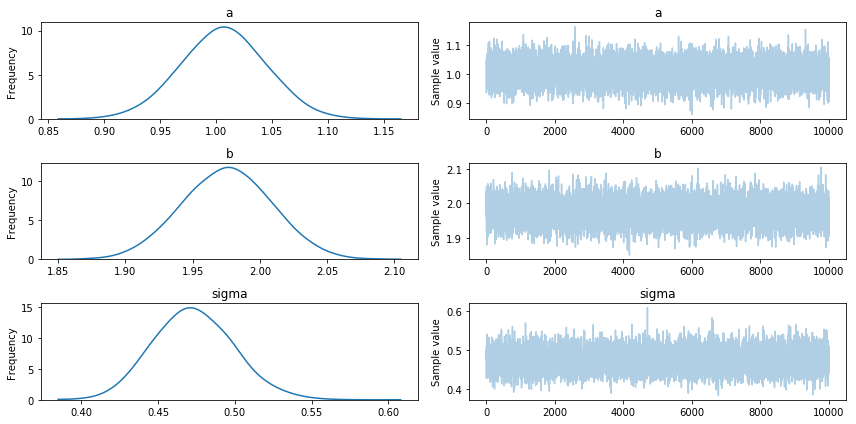

In [36]:
advi_trace = advi_fit.sample(10000)
display(pm.summary(advi_trace))
pm.traceplot(advi_trace)

In [ ]:
advi_elbo = pd.DataFrame(
    {'log-ELBO': -np.log(advi_fit.hist),
     'n': np.arange(advi_fit.hist.shape[0])})

sns.lineplot(y='log-ELBO', x='n', data=advi_elbo)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


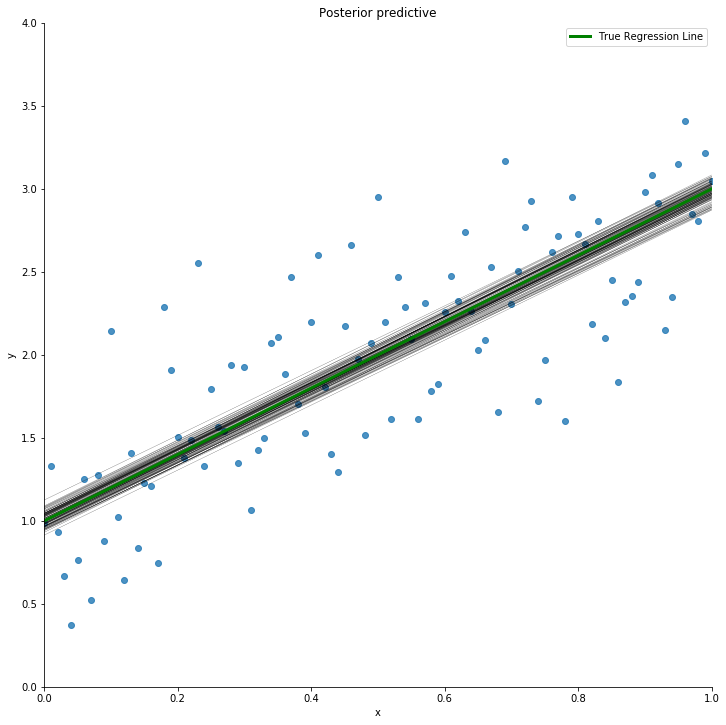

In [23]:
# Plot a sample of posterior regression lines
sns.lmplot(x="x", y="y", data=df, size=10, fit_reg=False)
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 4.0)
pm.plot_posterior_predictive_glm(advi_trace, samples=100)
x = np.linspace(0, 1, N)
y = beta_0 + beta_1*x
plt.plot(x, y, label="True Regression Line", lw=3., c="green")
plt.legend(loc=0)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


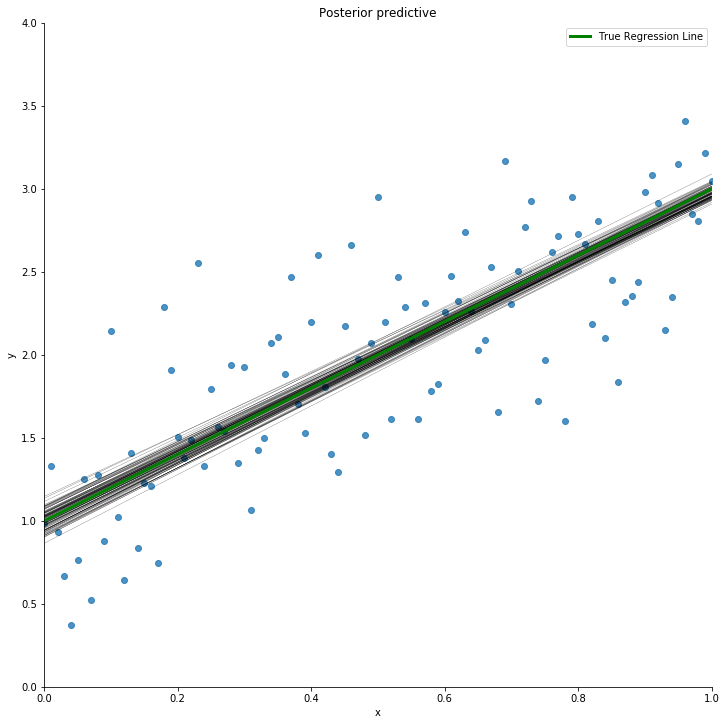

In [25]:
# Plot a sample of posterior regression lines
sns.lmplot(x="x", y="y", data=df, size=10, fit_reg=False)
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 4.0)
pm.plot_posterior_predictive_glm(trace, samples=100)
x = np.linspace(0, 1, N)
y = beta_0 + beta_1*x
plt.plot(x, y, label="True Regression Line", lw=3., c="green")
plt.legend(loc=0)
plt.show()